In [4]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage

In [5]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from keras.layers import Lambda

In [9]:
fine = np.load("ERA_wind\\ERA_wind.npz")

u = fine.get('wind_u')
v = fine.get('wind_v')

#wind_speeds = [[[np.sqrt((u[i][1][lat][lon])**2 + (v[i][1][lat][lon])**2) for lon in range(201)] for lat in range(121)] for i in range(744)]

wind_v = fine["wind_v"][:744, 0, :120, :200]
wind_u = fine["wind_u"][:744, 0, :120, :200]
wind_scalar = [np.sqrt(arr1**2 + arr2**2) for arr1, arr2 in zip(wind_v, wind_u)] # create array with wind scalar vales


len(wind_speeds), len(wind_speeds[0]), len(wind_speeds[0][0])


NameError: name 'wind_speeds' is not defined

In [10]:
## Train Data

train_files = os.listdir("train")

coarse_train = []
fine_train = []
for file in train_files: # loop thru files
    if file[0]=="w":
        timestamp = file[19:-4]
        coarse_train.append(np.load(str("train/" + file))) # load file, save into coarse
        fine_train.append(wind_scalar[int(timestamp)]) # load fine version


In [11]:
## Test Data

test_files = os.listdir("test")

test_files

coarse_test = []
fine_test = []
for file in test_files: # loop thru files
    if file[0]=="w":
        timestamp = file[19:-4]
        coarse_test.append(np.load(str("test/" + file))) # load file, save into coarse
        fine_test.append(wind_scalar[int(timestamp)]) # load fine version

In [12]:
## Val Data

val_files = os.listdir("val")

coarse_val = []
fine_val = []
for file in val_files: # loop thru files
    if file[0]=="w":
        timestamp = file[19:-4]
        coarse_val.append(np.load(str("val/" + file))) # load file, save into coarse
        fine_val.append(wind_scalar[int(timestamp)]) # load fine version

In [13]:
## CNN

import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from torch import tensor, argmax

class PairedImageDataset(Dataset):
    def __init__(self, coarse_images, high_res_images, transform=None):
        self.coarse_images = coarse_images
        self.high_res_images = high_res_images
        self.transform = transform

    def __len__(self):
        return len(self.coarse_images)

    def __getitem__(self, idx):
        coarse_img = self.coarse_images[idx]
        high_res_img = self.high_res_images[idx]

        if self.transform:
            coarse_img = self.transform(coarse_img)
            high_res_img = self.transform(high_res_img)

        return coarse_img, high_res_img

transform = transforms.Compose([
    transforms.ToPILImage(),
#   transforms.Resize((121,201)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train = PairedImageDataset(tensor(np.array(coarse_train)), tensor(np.array(fine_train)), transform=transform)
test = PairedImageDataset(tensor(np.array(coarse_test)), tensor(np.array(fine_test)), transform=transform)
val = PairedImageDataset(tensor(np.array(coarse_val)), tensor(np.array(fine_val)), transform=transform)

# load
batch_size = 16
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

c:\Users\17735\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\17735\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


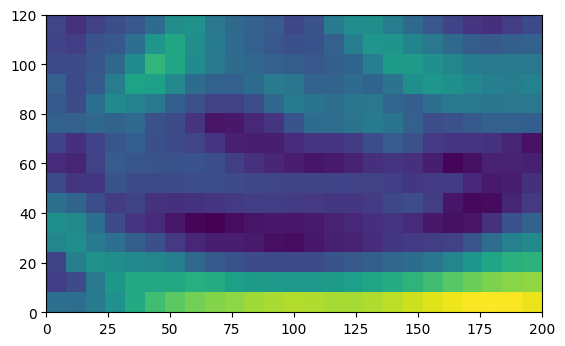

In [14]:
plt.imshow(coarse_train[0], origin='lower', cmap='viridis', extent=[0, 200, 0, 120])


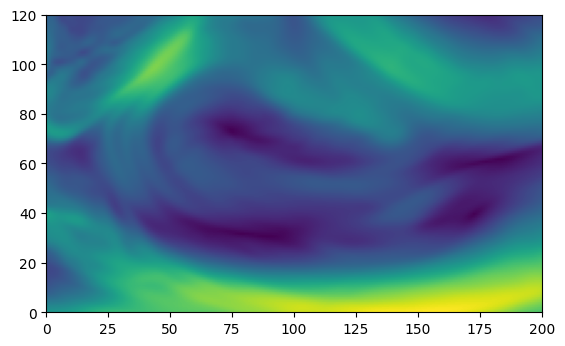

In [15]:
plt.imshow(fine_train[0], origin='lower', cmap='viridis', extent=[0, 200, 0, 120])


In [16]:
class CNN(nn.Module):
    def __init__(self):
        upscale = 8
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(16, upscale**2, kernel_size=3, padding= 1),
            nn.ReLU()
        )
        self.depth_to_space = nn.PixelShuffle(upscale)
        
    def forward(self, x):
        x = self.conv_layers(x.float())
        x = self.depth_to_space(x)
        return x
    
model = CNN()

In [17]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [21]:
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=0.00001)
loss_values = []
val_loss_values = []
mape_list = []
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        total_mape = 0.0
        num_batches = 0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, targets.squeeze())
            absolute_percentage_error = np.abs(np.abs(targets - outputs) / targets)
            print(absolute_percentage_error)
            mape = absolute_percentage_error.mean().item() * 100
            print(mape)
            total_mape += mape
            print(total_mape)
            num_batches += 1

        epoch_mape = total_mape / num_batches
        mape_list.append(epoch_mape)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val MAPE: {epoch_mape}')
    loss_values.append(loss.item())
    val_loss_values.append(val_loss.item())

c:\Users\17735\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16, 120, 200])) that is different to the input size (torch.Size([16, 1, 120, 200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\17735\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([11, 120, 200])) that is different to the input size (torch.Size([11, 1, 120, 200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[[[2.4877e+00, 4.7998e-01, 6.3399e-01,  ..., 5.9152e-01,
           6.7050e-01, 8.2617e-01],
          [4.3226e-01, 3.9310e-01, 7.4900e-01,  ..., 7.5466e-01,
           8.4104e+00, 1.1807e-01],
          [6.0191e-01, 7.8338e-01, 8.8075e-01,  ..., 1.2337e-01,
           4.0059e-01, 7.2451e-01],
          ...,
          [3.8104e-02, 8.8721e-02, 4.1047e-01,  ..., 7.3708e-01,
           2.2487e-01, 6.1118e-01],
          [1.0000e+00, 6.8685e-01, 2.5382e-01,  ..., 7.5355e-01,
           9.2864e-01, 3.5622e-01],
          [2.8674e-01, 7.7192e-01, 1.0000e+00,  ..., 4.8159e-01,
           6.9692e-01, 5.0515e-02]]],


        [[[1.4361e-01, 5.0086e-01, 5.0972e-01,  ..., 3.2919e-01,
           1.6013e+00, 7.4284e-01],
          [4.9830e-02, 1.9285e-01, 5.7674e-01,  ..., 1.2341e-01,
           6.5105e-01, 6.3385e-01],
          [6.7873e-01, 7.8557e-01, 2.3127e+00,  ..., 7.0074e-01,
           5.8301e-01, 4.4749e-01],
          ...,
          [3.4529e-01, 2.9989e-01, 6.4666e-01,  ..., 1.88

tensor([[[[0.3511, 0.2298, 0.2734,  ..., 0.3050, 0.3307, 0.2252],
          [0.3270, 0.3512, 0.2342,  ..., 0.2880, 0.3724, 0.2641],
          [0.2799, 0.2349, 0.3355,  ..., 0.3187, 0.3194, 0.2154],
          ...,
          [0.2908, 0.3522, 0.3046,  ..., 0.2800, 0.3046, 0.3183],
          [0.0000, 0.3162, 0.3391,  ..., 0.2399, 0.3619, 0.3520],
          [0.3382, 0.2485, 0.0000,  ..., 0.3602, 0.3190, 0.2986]]]])


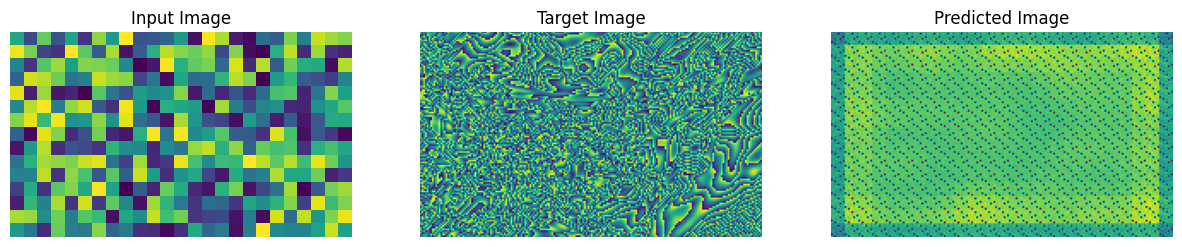

In [22]:
# Get one batch of samples from the training data
dataiter = iter(test_loader)
input_images, target_images = next(dataiter)

# Select one image from the batch
index = 5  # Choose the index of the image you want to plot
input_image = input_images[index]
target_image = target_images[index]

model.eval()

# Make prediction using the CNN model
with torch.no_grad():
    predicted_image = model(input_image.unsqueeze(0))  # Add an extra dimension for batch

print(predicted_image)

# Plot the input image, target image, and predicted image side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the input image
axes[0].imshow(input_image.squeeze())
axes[0].set_title('Input Image')
axes[0].axis('off')

# Plot the target image
axes[1].imshow(target_image.squeeze())
axes[1].set_title('Target Image')
axes[1].axis('off')

# Plot the predicted image
axes[2].imshow(predicted_image.squeeze().cpu().numpy())
axes[2].set_title('Predicted Image')
axes[2].axis('off')

plt.show()


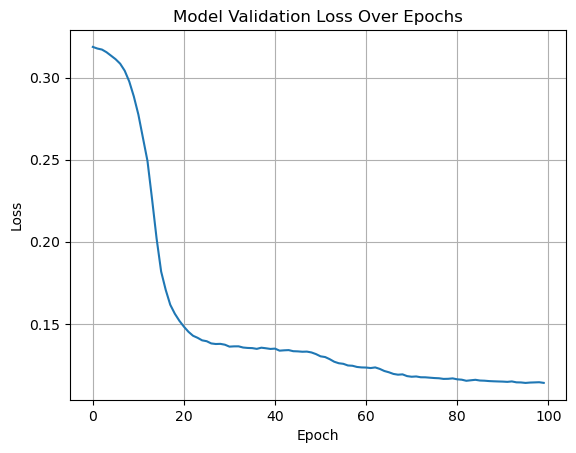

In [ ]:
plt.plot(val_loss_values, linestyle='-')
plt.title('Model Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

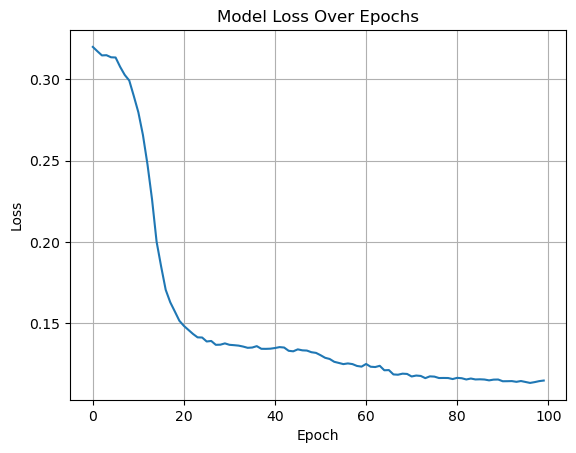

In [ ]:
plt.plot(loss_values, linestyle='-')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()